In [2]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pprint import pprint

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
with open('/content/sample_data/input.txt', 'r') as file:
    text = file.read()

In [4]:
text

"First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you know Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us kill him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be done: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citizens, the patricians good.\nWhat authority surfeits on would relieve us: if they\nwould yield us but the superfluity, while it were\nwholesome, we might guess they relieved us humanely;\nbut they think we are too dear: the leanness that\nafflicts us, the object of our misery, is as an\ninventory to particularise their abundance; our\nsufferance is a gain to them Let us revenge this with\nour pikes, ere we become rakes: for the gods know I\nspeak this in hunger 

In [7]:
tokens = text.split()

In [ ]:
tokens

['First',
 'Citizen:',
 'Before',
 'we',
 'proceed',
 'any',
 'further,',
 'hear',
 'me',
 'speak.',
 'All:',
 'Speak,',
 'speak.',
 'First',
 'Citizen:',
 'You',
 'are',
 'all',
 'resolved',
 'rather',
 'to',
 'die',
 'than',
 'to',
 'famish?',
 'All:',
 'Resolved.',
 'resolved.',
 'First',
 'Citizen:',
 'First,',
 'you',
 'know',
 'Caius',
 'Marcius',
 'is',
 'chief',
 'enemy',
 'to',
 'the',
 'people.',
 'All:',
 'We',
 "know't,",
 'we',
 "know't.",
 'First',
 'Citizen:',
 'Let',
 'us',
 'kill',
 'him,',
 'and',
 "we'll",
 'have',
 'corn',
 'at',
 'our',
 'own',
 'price.',
 "Is't",
 'a',
 'verdict?',
 'All:',
 'No',
 'more',
 'talking',
 "on't;",
 'let',
 'it',
 'be',
 'done:',
 'away,',
 'away!',
 'Second',
 'Citizen:',
 'One',
 'word,',
 'good',
 'citizens.',
 'First',
 'Citizen:',
 'We',
 'are',
 'accounted',
 'poor',
 'citizens,',
 'the',
 'patricians',
 'good.',
 'What',
 'authority',
 'surfeits',
 'on',
 'would',
 'relieve',
 'us:',
 'if',
 'they',
 'would',
 'yield',
 'us',
 

In [ ]:
len(tokens)

202651

In [8]:
# Step 2: Create a vocabulary
vocab = sorted(set(tokens))
stoi = {word: i for i, word in enumerate(vocab)}
itos = {i: word for word, i in stoi.items()}
vocab_size = len(vocab)

In [38]:
# Step 3: Generate training samples
def train_sample(block_size):
  X, Y = [], []
  for i in range(len(tokens) - block_size):
      context = [stoi[tokens[i+j]] for j in range(block_size)]
      target = stoi[tokens[i + block_size]]
      X.append(context)
      Y.append(target)
      # training_data.append((context, target))
  X = torch.tensor(X).to(device)
  Y = torch.tensor(Y).to(device)
  return X,Y

In [37]:
# Embedding layer for the context
emb_dim = 150
emb = torch.nn.Embedding(len(stoi), emb_dim)

In [39]:
emb.weight

Parameter containing:
tensor([[ 1.2795,  1.0797, -0.1164,  ..., -0.2528,  0.1147, -0.4723],
        [ 0.9202, -0.7557, -0.0932,  ...,  2.2286,  0.1128, -0.3585],
        [ 1.4925,  0.4142,  0.1116,  ...,  0.7438,  1.3987,  0.2937],
        ...,
        [ 2.0415,  0.2878,  0.3196,  ...,  1.1064,  1.1959, -0.2752],
        [ 0.0204,  0.0700,  0.4542,  ...,  1.3970, -0.0614,  0.2826],
        [ 0.7175,  0.1831, -0.4377,  ..., -1.3423,  0.3106,  0.1799]],
       requires_grad=True)

In [40]:
emb.weight.shape

torch.Size([25670, 150])

**Visualising our vocabulary using T-sne**

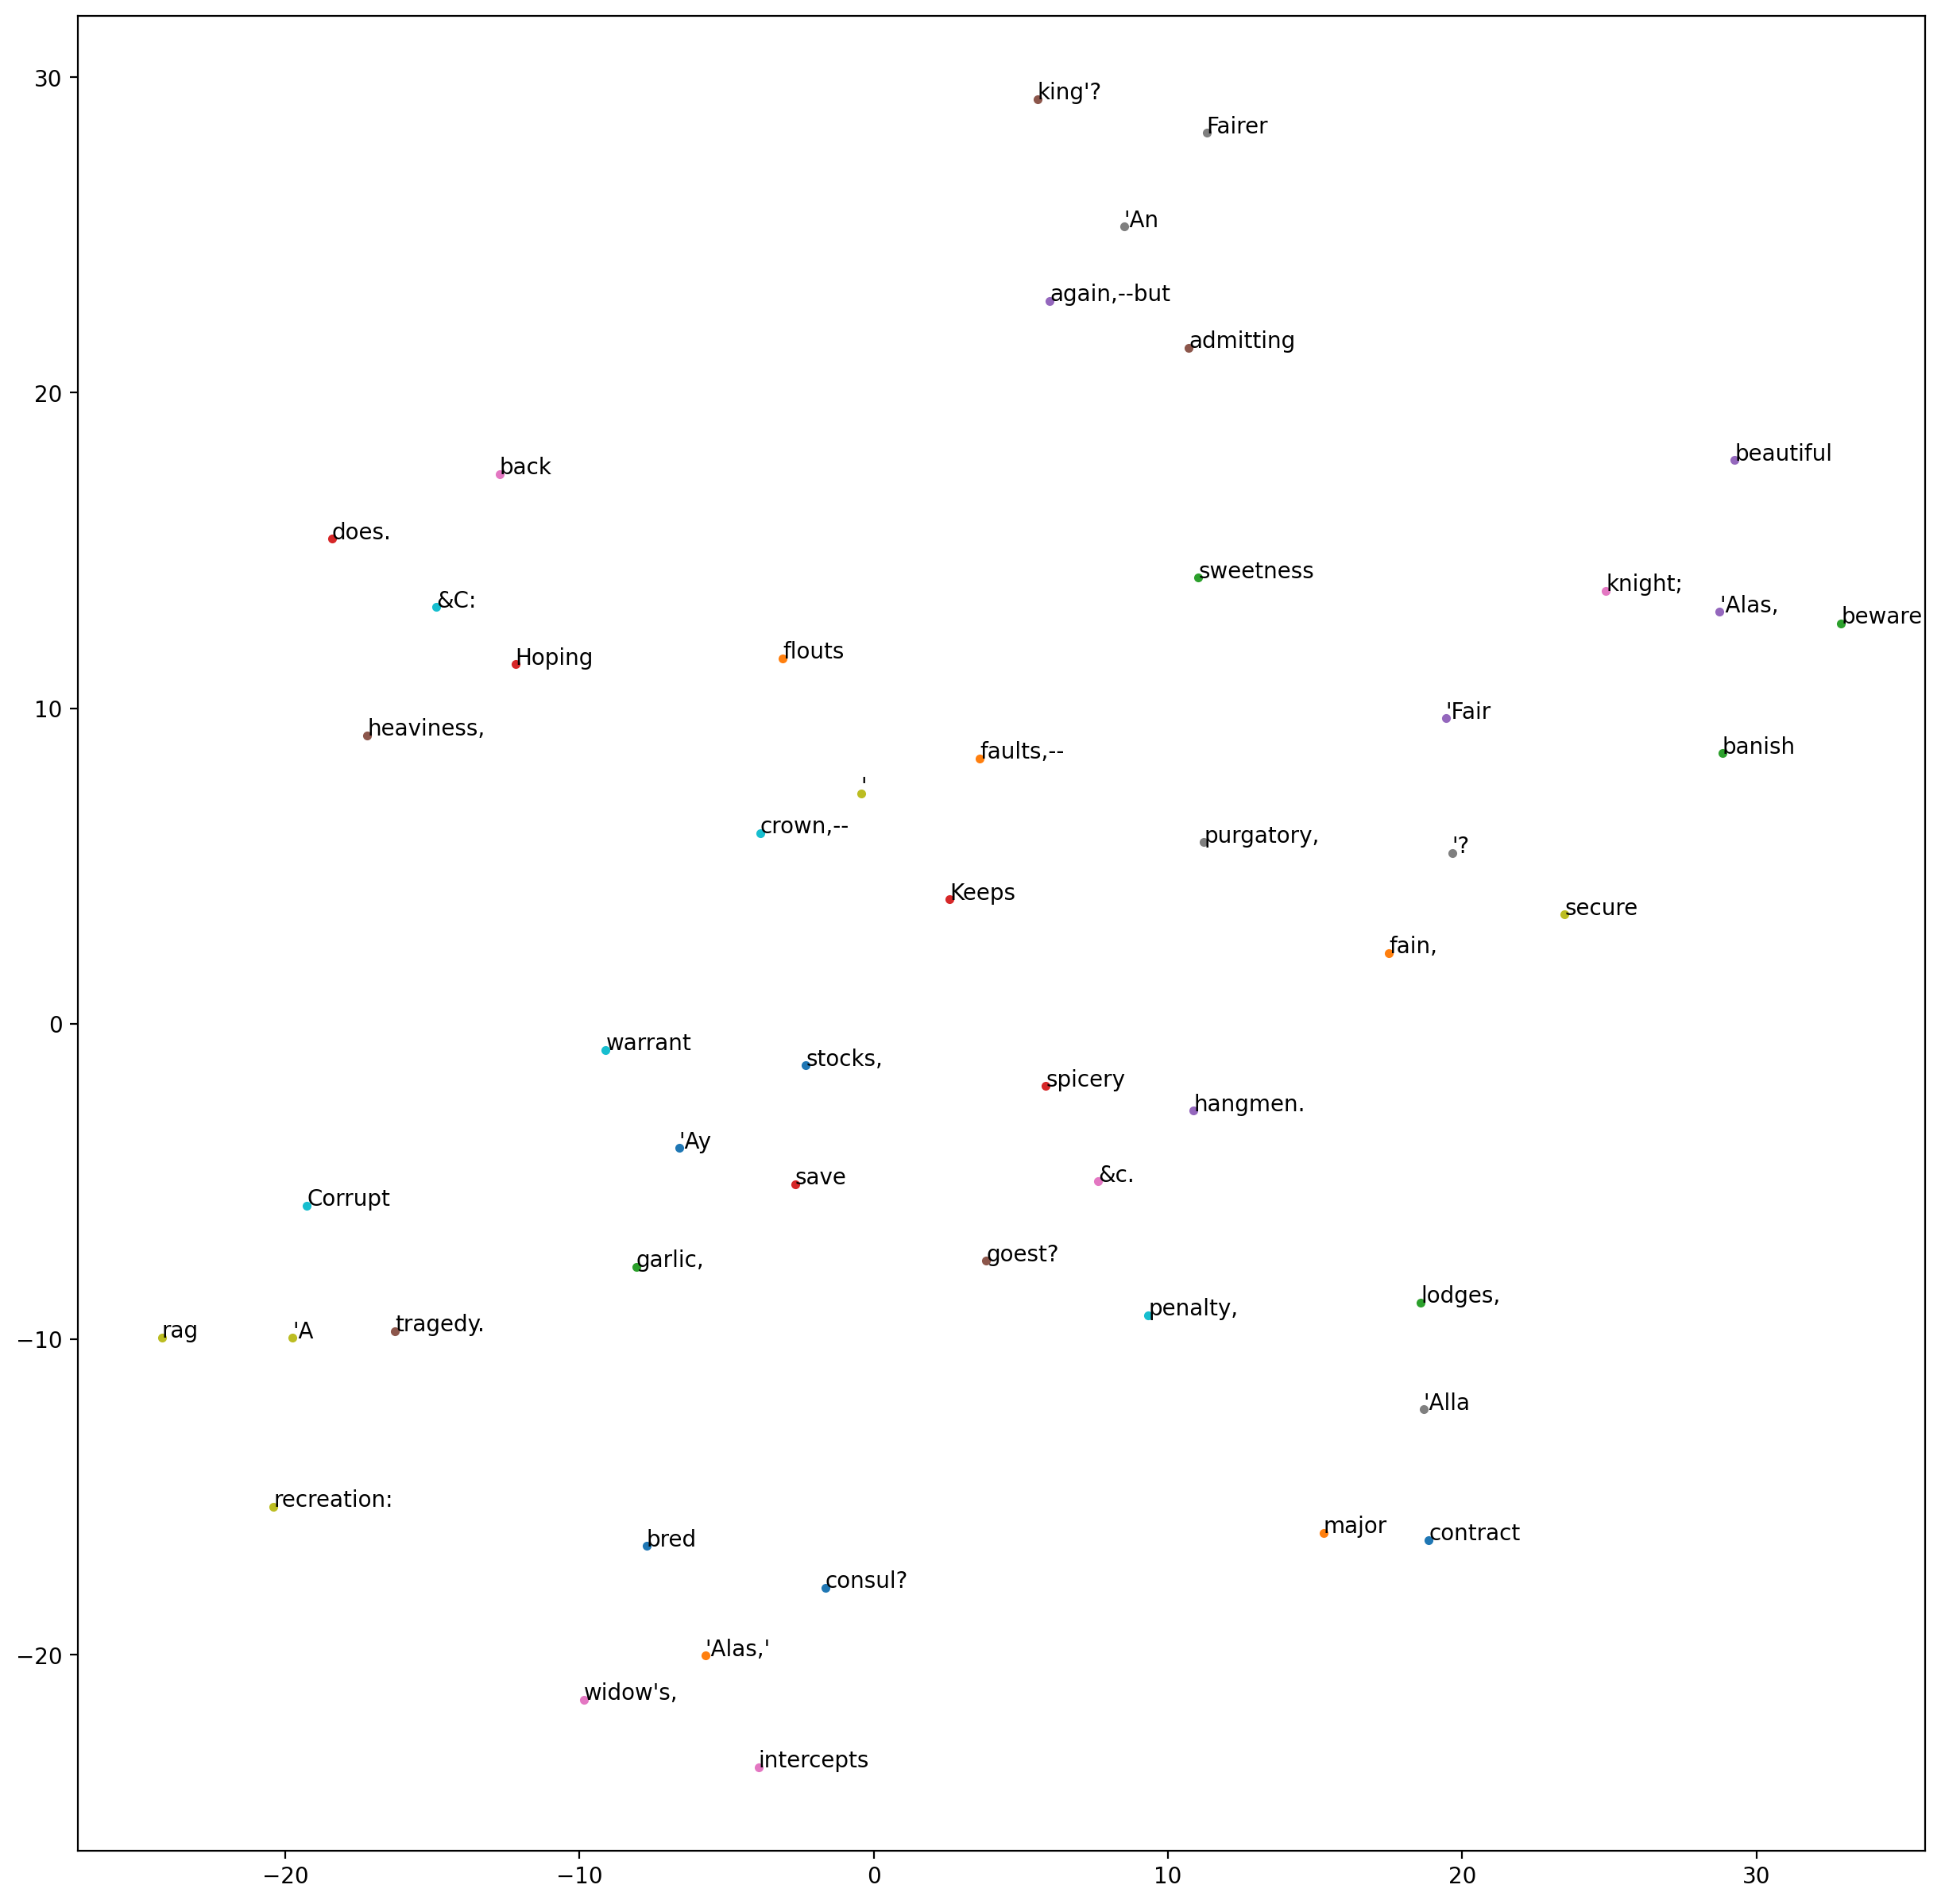

In [41]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# we have a vocabulary of 25,670 words and a 25,670 x 150 embedding matrix called 'embeddings_matrix'
embeddings_matrix = emb.weight
embeddings_matrix= embeddings_matrix.detach()

# Also we a list of target words called 'target_words'
target_words = vocab[:10]
target_indices = [vocab.index(word) for word in target_words]
target_embeddings = embeddings_matrix[target_indices]

# Compute cosine similarity with all other words
similarities = cosine_similarity(target_embeddings, embeddings_matrix)

# Get top N related words for each target word
num_related_words = 5
related_words = []
for i, target_word in enumerate(target_words):
    related_word_indices = np.argsort(-similarities[i])[:num_related_words]
    related_words.append([vocab[idx] for idx in related_word_indices])

# Flatten the list of related words
flat_related_words = [word for sublist in related_words for word in sublist]

# Get unique words and their embeddings
unique_words = list(set(flat_related_words))
unique_word_indices = [vocab.index(word) for word in unique_words]
unique_word_embeddings = embeddings_matrix[unique_word_indices]

# Reduce dimensionality with t-SNE
tsne = TSNE(n_components=2, perplexity=10, random_state=42)
embeddings_2d = tsne.fit_transform(unique_word_embeddings)

# Plot the embeddings
plt.figure(figsize=(15, 15))
for i in range(len(unique_words)):
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], marker='.')
    plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], unique_words[i])

plt.show()


In [11]:
class NextChar(nn.Module):
  def __init__(self, block_size, vocab_size, emb_dim, hidden_size):
    super().__init__()
    self.emb = nn.Embedding(vocab_size, emb_dim)
    self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
    self.lin2 = nn.Linear(hidden_size, hidden_size)
    self.lin3 = nn.Linear(hidden_size, vocab_size)

  def forward(self, x):
    x = self.emb(x)
    x = x.view(x.shape[0], -1)
    x = torch.sin(self.lin1(x))
    x = torch.sin(self.lin2(x))
    x = self.lin3(x)
    return x

In [ ]:
# # Generate names from untrained model

# model = NextChar(block_size, len(stoi), emb_dim, 64).to(device)
# # model = torch.compile(model)


In [34]:
def generate_text(model, itos, stoi, block_size, context ,max_len=10):
    name = ''
    for i in range(max_len):
        x = torch.tensor(context).view(1, -1).to(device)
        y_pred = model(x)
        ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
        ch = itos[ix]
        name =name+' '+ch
        context = context[1:] + [ix]
    return name



In [14]:
# Train the model
def train(model,X,Y):
    loss_fn = nn.CrossEntropyLoss()
    opt = torch.optim.AdamW(model.parameters(), lr=0.001)
    import time
    # Mini-batch training
    batch_size = 4096
    print_every = 100
    elapsed_time = []
    for epoch in range(500):
        for i in range(0, X.shape[0], batch_size):
            x = X[i:i+batch_size]
            y = Y[i:i+batch_size]
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            loss.backward()
            opt.step()
            opt.zero_grad()
        if epoch % print_every == 0:
            print(epoch, loss.item())


In [32]:
# context sizes
block_size_3 = 3
block_size_5 = 5
block_size_7 = 7
block_size_10 = 10

**Model1** **with context size 10**

In [18]:
#Training sample for context size 10
X_10,Y_10 = train_sample(block_size_10)
X_10.shape, Y_10.shape

(torch.Size([202641, 10]), torch.Size([202641]))

Embedding Dimension 150

In [ ]:
model_10 = NextChar(block_size_10, len(stoi), emb_dim, 64).to(device)
train(model_10)

0 8.520100593566895
100 0.26953360438346863
200 0.013252783566713333
300 0.00166351068764925
400 0.0007249456830322742


In [ ]:
torch.save(model_10.state_dict(), 'model_10.pth')

Embedding Dimension 100

In [21]:
model_10_100 = NextChar(block_size_10, len(stoi), 100, 64).to(device)
train(model_10_100,X_10,Y_10)

0 8.466623306274414
100 0.802020251750946
200 0.02343655936419964
300 0.002524045994505286
400 0.0009833460208028555


In [22]:
model_10_100.cpu()

NextChar(
  (emb): Embedding(25670, 100)
  (lin1): Linear(in_features=1000, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=64, bias=True)
  (lin3): Linear(in_features=64, out_features=25670, bias=True)
)

In [23]:
torch.save(model_10_100.state_dict(), 'model_10_100.pth')

Embedding Dimension 50

In [24]:
model_10_50 = NextChar(block_size_10, len(stoi), 50, 64).to(device)
train(model_10_50,X_10,Y_10)

0 8.701597213745117
100 1.3888317346572876
200 0.14212007820606232
300 0.025438230484724045
400 0.003970470279455185


In [25]:
model_10_50.cpu()

NextChar(
  (emb): Embedding(25670, 50)
  (lin1): Linear(in_features=500, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=64, bias=True)
  (lin3): Linear(in_features=64, out_features=25670, bias=True)
)

In [26]:
torch.save(model_10_50.state_dict(), 'model_10_50.pth')

**Model with context size 7**

In [27]:
# Training sample for context size 7
X_7,Y_7 = train_sample(block_size_7)
X_7.shape, Y_7.shape

(torch.Size([202644, 7]), torch.Size([202644]))

Embedding Dimension 150

In [ ]:
model_7 = NextChar(block_size_7, len(stoi), emb_dim, 64).to(device)
print("Training model with context size 7")
train(model_7,X_7,Y_7)

Training model with context size 7
0 8.494325637817383
100 0.32763800024986267
200 0.011932997964322567
300 0.0017692322144284844
400 0.0007494937162846327


In [ ]:
torch.save(model_7.state_dict(), 'model_7.pth')

Embedding Dimension 100

In [28]:
model_7_100 = NextChar(block_size_7, len(stoi), 100, 64).to(device)
print("Training model with context size 7 dim 100")
train(model_7_100,X_7,Y_7)

Training model with context size 7 dim 100
0 8.638842582702637
100 0.5537649393081665
200 0.033842772245407104
300 0.0030119845177978277
400 0.0008099453989416361


In [29]:
model_7_100.cpu()

NextChar(
  (emb): Embedding(25670, 100)
  (lin1): Linear(in_features=700, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=64, bias=True)
  (lin3): Linear(in_features=64, out_features=25670, bias=True)
)

In [30]:
torch.save(model_7_100.state_dict(), 'model_7_100.pth')

Embedding Dimension 50

In [31]:
model_7_50 = NextChar(block_size_7, len(stoi), 50, 64).to(device)
print("Training model with context size 7 dim 50")
train(model_7_50,X_7,Y_7)

Training model with context size 7 dim 50
0 8.76819896697998
100 1.6497626304626465
200 0.2794455587863922
300 0.07382411509752274
400 0.023273613303899765


In [32]:
model_7_50.cpu()

NextChar(
  (emb): Embedding(25670, 50)
  (lin1): Linear(in_features=350, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=64, bias=True)
  (lin3): Linear(in_features=64, out_features=25670, bias=True)
)

In [33]:
torch.save(model_7_50.state_dict(), 'model_7_50.pth')

**Model with context size 5**

In [53]:
# Training sample for context size 5
X_5,Y_5 = train_sample(block_size_5)
X_5.shape, Y_5.shape

(torch.Size([202646, 5]), torch.Size([202646]))

Embedding Dimension 150

In [54]:
model_5 = NextChar(block_size_5, len(stoi), emb_dim, 64).to(device)
print("Training model with context size 5")
train(model_5,X_5,Y_5)

Training model with context size 5
0 8.593339920043945
100 0.42569756507873535
200 0.033405642956495285
300 0.006557163782417774
400 0.0030212050769478083


In [ ]:
torch.save(model_5.state_dict(), 'model_5.pth')

Embedding Dimension 100

In [36]:
model_5_100 = NextChar(block_size_5, len(stoi), 100, 64).to(device)
print("Training model with context size 5 and Dimension 100")
train(model_5_100,X_5,Y_5)

Training model with context size 5 and Dimension 100
0 8.760416030883789
100 0.7521520256996155
200 0.087635338306427
300 0.019305745139718056
400 0.005104891490191221


In [37]:
model_5_100.cpu()

NextChar(
  (emb): Embedding(25670, 100)
  (lin1): Linear(in_features=500, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=64, bias=True)
  (lin3): Linear(in_features=64, out_features=25670, bias=True)
)

In [38]:
torch.save(model_5_100.state_dict(), 'model_5_100.pth')

Embedding Dimension 50

In [39]:
model_5_50 = NextChar(block_size_5, len(stoi), 50, 64).to(device)
print("Training model with context size 5 and Dimension 50")
train(model_5_50,X_5,Y_5)

Training model with context size 5 and Dimension 50
0 9.084678649902344
100 1.8497600555419922
200 0.43586820363998413
300 0.17461051046848297
400 0.09158533066511154


In [40]:
model_5_50.cpu()

NextChar(
  (emb): Embedding(25670, 50)
  (lin1): Linear(in_features=250, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=64, bias=True)
  (lin3): Linear(in_features=64, out_features=25670, bias=True)
)

In [41]:
torch.save(model_5_50.state_dict(), 'model_5_50.pth')

**Model with context size 3**

In [43]:
# Training sample for context size 3
X_3,Y_3 = train_sample(block_size_3)
X_3.shape, Y_3.shape

(torch.Size([202648, 3]), torch.Size([202648]))

Embedding Dimension 150

In [ ]:
model_3 = NextChar(block_size_3, len(stoi), emb_dim, 64).to(device)
print("Training model with context size 3")
train(model_3,X_3,Y_3)

Training model with context size 3
0 8.906829833984375
100 0.8180528283119202
200 0.23878131806850433
300 0.13969668745994568
400 0.10058385878801346


In [ ]:
torch.save(model_3.state_dict(), 'model_3.pth')

Embedding Dimension 100

In [44]:
model_3_100 = NextChar(block_size_3, len(stoi), 100, 64).to(device)
print("Training model with context size 3, dim 100")
train(model_3_100,X_3,Y_3)

Training model with context size 3, dim 100
0 8.826821327209473
100 1.2366394996643066
200 0.3682384788990021
300 0.21009819209575653
400 0.15574268996715546


In [45]:
model_3_100.cpu()

NextChar(
  (emb): Embedding(25670, 100)
  (lin1): Linear(in_features=300, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=64, bias=True)
  (lin3): Linear(in_features=64, out_features=25670, bias=True)
)

In [46]:
torch.save(model_3_100.state_dict(), 'model_3_100.pth')

Embedding Dimension 50

In [47]:
model_3_50 = NextChar(block_size_3, len(stoi), 50, 64).to(device)
print("Training model with context size 3, dim 50")
train(model_3_50,X_3,Y_3)

Training model with context size 3, dim 50
0 9.210173606872559
100 2.058736801147461
200 0.7496277689933777
300 0.4786922335624695
400 0.3852311372756958


In [48]:
model_3_50.cpu()

NextChar(
  (emb): Embedding(25670, 50)
  (lin1): Linear(in_features=150, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=64, bias=True)
  (lin3): Linear(in_features=64, out_features=25670, bias=True)
)

In [49]:
torch.save(model_3_50.state_dict(), 'model_3_50.pth')

In [16]:
def createContext(input_text,block_size):
  input_text= input_text.split()
  input_text= input_text[-block_size:]
  context = [stoi[input_text[j]] for j in range(block_size)]
  return context


**Models predecition**

Model with context size 10 prediction

In [51]:
input_string = 'I have fought with thee: so often hast thou beat me, And wouldst'
context = createContext(input_string,block_size_10)
nextk = 10
pprint(generate_text(model_10, itos, stoi, block_size_10 , context , max_len= nextk))

' tell to did instantly. money; Hath my brother: sir. BAGOT:'


Loading model 5 and predicting

In [14]:
model_5 = NextChar(5,len(stoi),150,64)

In [30]:
model_5.load_state_dict(torch.load('/content/sample_data/model_5 (1).pth'))

<All keys matched successfully>

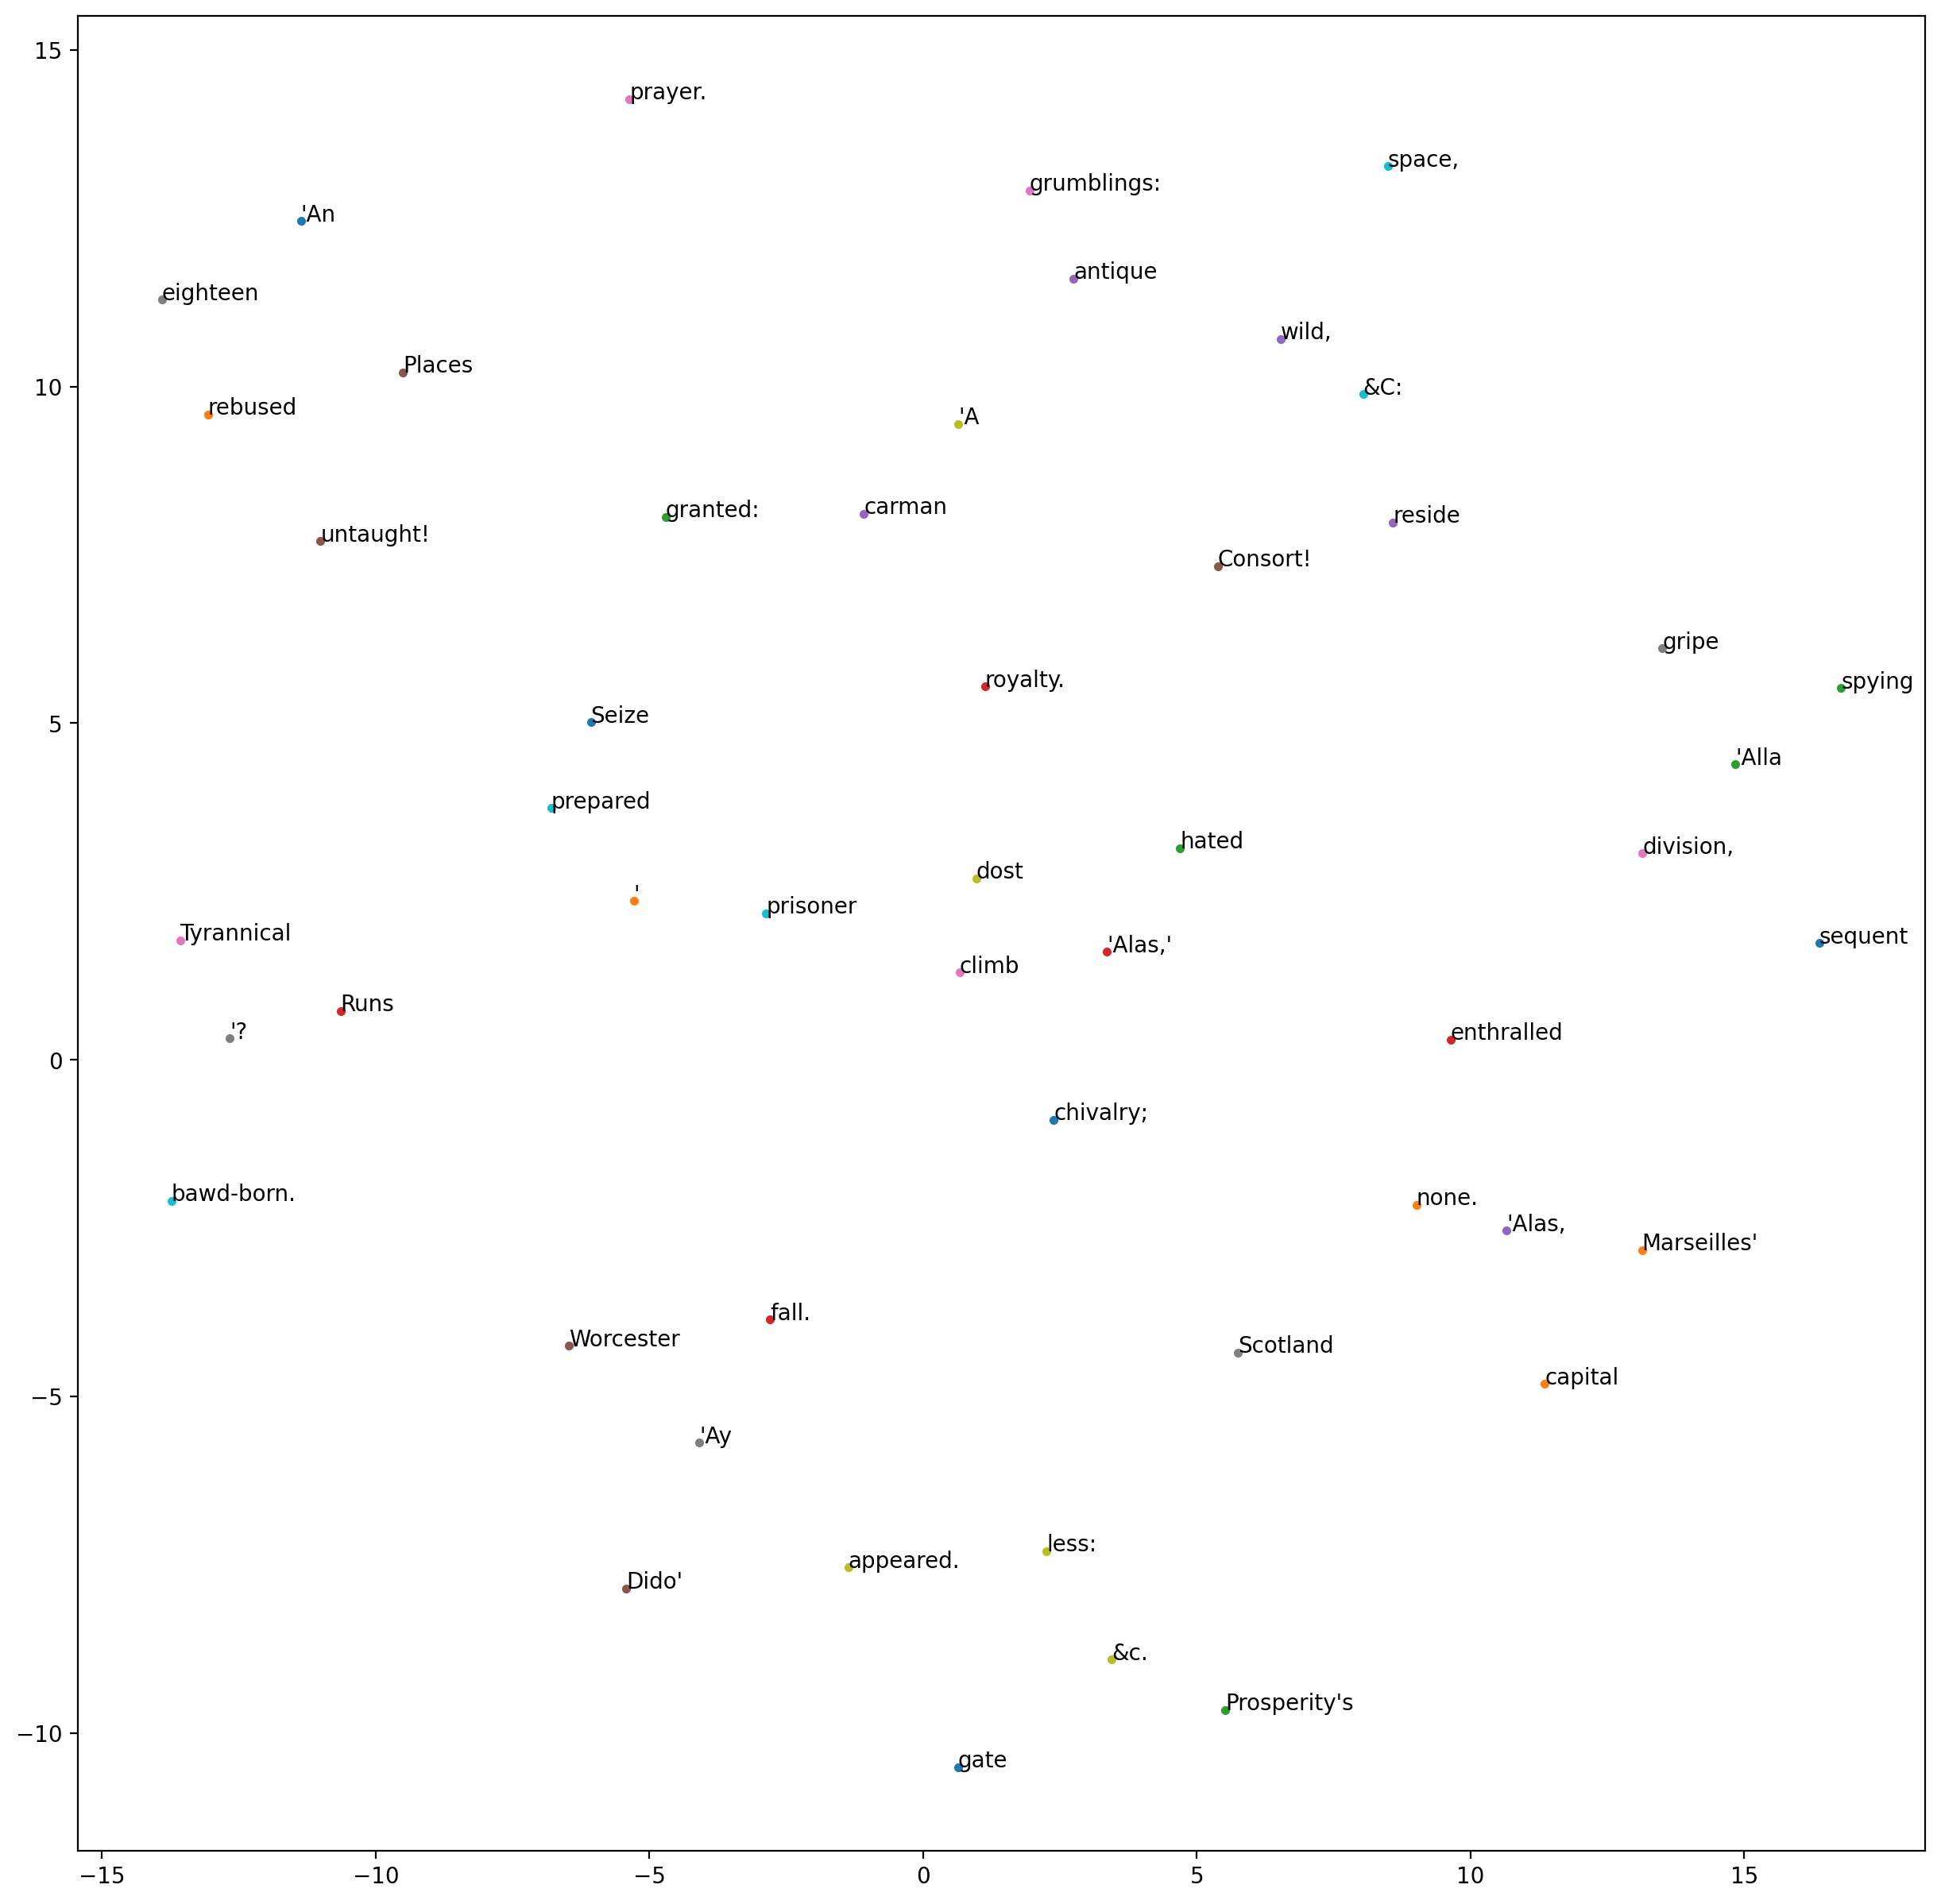

In [49]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# we have a vocabulary of 25,670 words and a 25,670 x 150 embedding matrix called 'embeddings_matrix'
embeddings_matrix = model_5.emb.weight
embeddings_matrix= embeddings_matrix.detach()

# Also we a list of target words called 'target_words'
target_words = vocab[:10]
target_indices = [vocab.index(word) for word in target_words]
target_embeddings = embeddings_matrix[target_indices]

# Compute cosine similarity with all other words
similarities = cosine_similarity(target_embeddings, embeddings_matrix)

# Get top N related words for each target word
num_related_words = 5
related_words = []
for i, target_word in enumerate(target_words):
    related_word_indices = np.argsort(-similarities[i])[:num_related_words]
    related_words.append([vocab[idx] for idx in related_word_indices])

# Flatten the list of related words
flat_related_words = [word for sublist in related_words for word in sublist]

# Get unique words and their embeddings
unique_words = list(set(flat_related_words))
unique_word_indices = [vocab.index(word) for word in unique_words]
unique_word_embeddings = embeddings_matrix[unique_word_indices]

# Reduce dimensionality with t-SNE
tsne = TSNE(n_components=2, perplexity=10, random_state=42)
embeddings_2d = tsne.fit_transform(unique_word_embeddings)

# Plot the embeddings
plt.figure(figsize=(15, 15))
for i in range(len(unique_words)):
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], marker='.')
    plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], unique_words[i])

plt.show()


In [35]:
input_string = 'We are accounted poor citizens, the patricians good. What authority surfeits on would relieve us:'
context = createContext(input_string,block_size_5)
nextk = 50
pprint(generate_text(model_5, itos, stoi, block_size_5 , context , max_len= nextk))

(' if they would yield us but the superfluity, while it were wholesome, we '
 'might guess they relieved us humanely; but they think we are too dear: the '
 'leanness that afflicts us, the object of our misery, is as an inventory to '
 'particularise their abundance; our sufferance is a gain to')
